In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
import matplotlib.pyplot as plt
import shap
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../src') 

from data_pipeline.extractor import execute_query
from gams.logistic_gam import train_logistic_gam_model
from ml_models.random_forest import train_random_forest_model
from ml_models.evalauion_results import evaluate_model

In [2]:
query = """
SELECT s.*, a.hospital_expire_flag as mortality
FROM sapsii s
LEFT JOIN admissions a
ON s.subject_id = a.subject_id
AND s.hadm_id = a.hadm_id;
"""

df = execute_query(query)

In [3]:
df.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'sapsii', 'sapsii_prob',
       'age_score', 'hr_score', 'sysbp_score', 'temp_score', 'pao2fio2_score',
       'uo_score', 'bun_score', 'wbc_score', 'potassium_score', 'sodium_score',
       'bicarbonate_score', 'bilirubin_score', 'gcs_score',
       'comorbidity_score', 'admissiontype_score', 'mortality'],
      dtype='object')

In [5]:
# Exclude specific columns
df_filtered = df.drop(columns=['subject_id', 'hadm_id', 'icustay_id', 'sapsii', 'sapsii_prob'])

# Replace NaNs with 0
df_filtered = df_filtered.fillna(0)


# # Separate majority and minority classes
# df_majority = df_filtered[df_filtered.mortality == 0]
# df_minority = df_filtered[df_filtered.mortality == 1]

# # Downsample majority class
# df_majority_downsampled = resample(df_majority, 
#                                    replace=False,    # sample without replacement
#                                    n_samples=int(len(df_minority)),  # to match minority class
#                                    random_state=42)  # reproducible results

# # Combine minority class with downsampled majority class
# df_balanced = pd.concat([df_majority_downsampled, df_minority])

# Separate features and target variable
y_balanced = df_filtered['mortality']
X_balanced = df_filtered.drop(columns=['mortality'])

# Split the balanced data into training and test sets
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced)

# Print class distribution after the split
print("Training set class distribution:")
print(y_train_balanced.value_counts())

print("Test set class distribution:")
print(y_test_balanced.value_counts())

Training set class distribution:
mortality
0    43938
1     5287
Name: count, dtype: int64
Test set class distribution:
mortality
0    10985
1     1322
Name: count, dtype: int64


In [6]:
# Standardize the data
scaler = StandardScaler()
X_train_balanced = scaler.fit_transform(X_train_balanced)
X_test_balanced = scaler.transform(X_test_balanced)

# 1. LogisticGam Model

In [7]:
gam_model, results = train_logistic_gam_model(X_train_balanced, y_train_balanced, X_test_balanced)

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     38.9674
Link Function:                        LogitLink Log Likelihood:                                -12567.9528
Number of Samples:                        49225 AIC:                                            25213.8404
                                                AICc:                                            25213.907
                                                UBRE:                                               2.5128
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2514
Feature Function                  Lam

In [8]:
print(f"Training Accuracy of the LogisticGAM model: {results['training_accuracy']:.4f}")

Training Accuracy of the LogisticGAM model: 0.9029


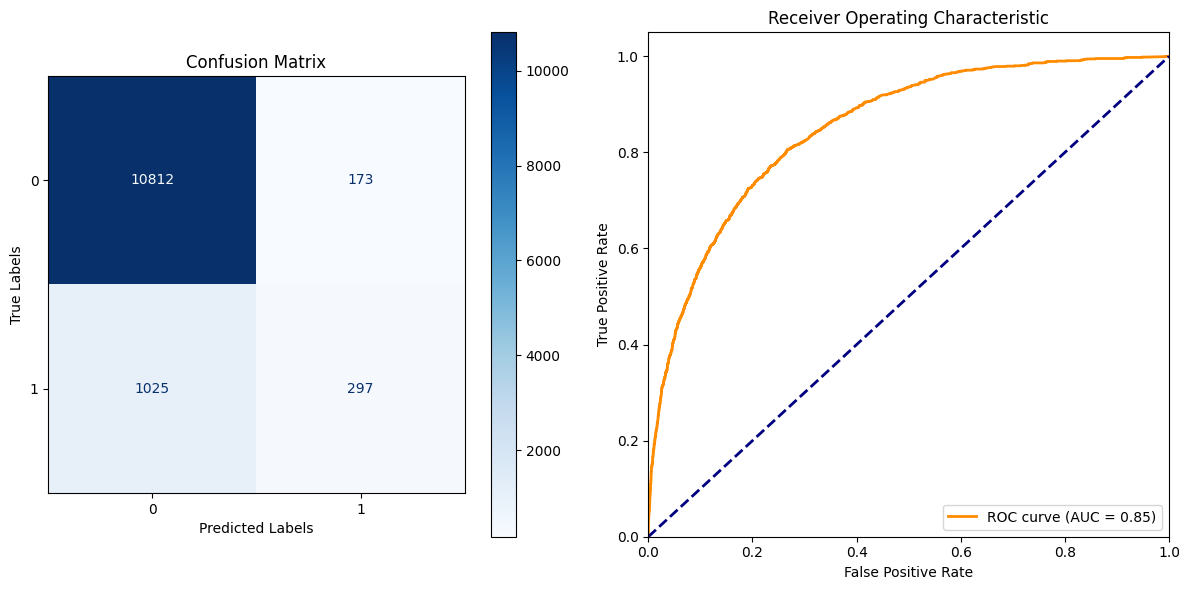

ROC AUC Score: 0.8504
Precision-Recall AUC Score: 0.4667
Test Accuracy: 0.9027
F1 Score: 0.3315

Confusion Matrix:
[[10812   173]
 [ 1025   297]]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.98      0.95     10985
           1       0.63      0.22      0.33      1322

    accuracy                           0.90     12307
   macro avg       0.77      0.60      0.64     12307
weighted avg       0.88      0.90      0.88     12307



In [9]:
evaluation_results = evaluate_model(y_test_balanced, results['y_pred'], results['y_pred_prob'])
# Print the ROC AUC and Precision-Recall AUC Scores
print(f"ROC AUC Score: {evaluation_results['roc_auc']:.4f}")
print(f"Precision-Recall AUC Score: {evaluation_results['roc_prc']:.4f}")

# Print the Test Accuracy and F1 Score
print(f"Test Accuracy: {evaluation_results['test_accuracy']:.4f}")
print(f"F1 Score: {evaluation_results['f1_score']:.4f}")

# Print the Confusion Matrix
print("\nConfusion Matrix:")
print(evaluation_results['confusion_matrix'])

report = evaluation_results['classification_report']
print("Classification Report:\n", report)


  0%|          | 0/2644 [00:00<?, ?it/s]

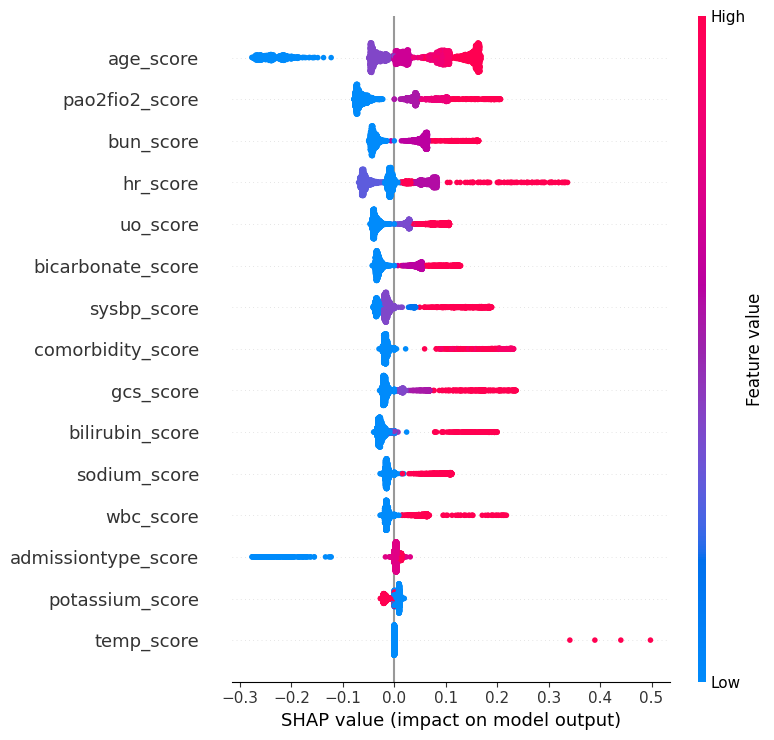

In [36]:
# Function to predict probabilities using the trained GAM model
def predict_gam_proba(X):
    return gam_model.predict_proba(X)

# Reduce the size of the background data by randomly sampling
background_data_balanced = shap.sample(X_train_balanced, 100)  # Select 100 samples for the background

# Use the KernelExplainer for SHAP values with reduced background data
explainer_balanced = shap.KernelExplainer(predict_gam_proba, background_data_balanced)
shap_values_balanced = explainer_balanced.shap_values(X_test_balanced, nsamples=100)  # Adjust nsamples as needed


# Plot SHAP summary plot
shap.summary_plot(shap_values_balanced, X_test_balanced, feature_names=X_balanced.columns)


# 2. Random Forest Model

In [10]:
rf_model, results = train_random_forest_model(
    X_train_balanced, y_train_balanced, X_test_balanced
)
print(f"Training Accuracy of the Random Forest model: {results['training_accuracy']:.4f}")

Training Accuracy of the Random Forest model: 0.9677


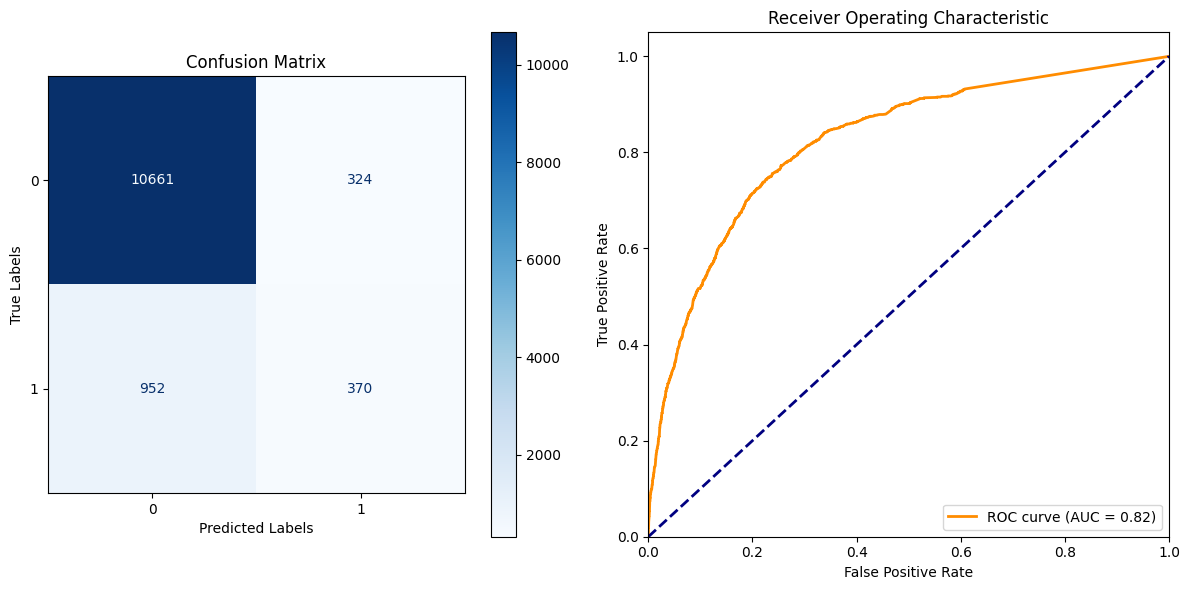

ROC AUC Score: 0.8227
Precision-Recall AUC Score: 0.4169
Test Accuracy: 0.8963
F1 Score: 0.3671

Confusion Matrix:
[[10661   324]
 [  952   370]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.97      0.94     10985
           1       0.53      0.28      0.37      1322

    accuracy                           0.90     12307
   macro avg       0.73      0.63      0.66     12307
weighted avg       0.88      0.90      0.88     12307



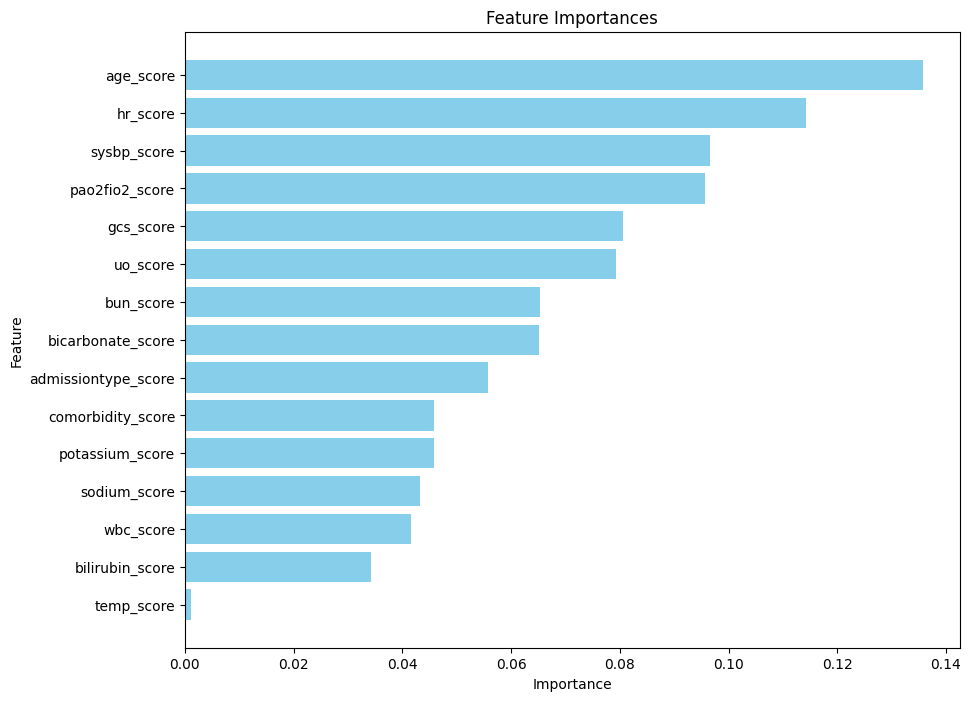

In [11]:
evaluation_results = evaluate_model(y_test_balanced, results['y_pred'], results['y_pred_prob'])
# Print the ROC AUC and Precision-Recall AUC Scores
print(f"ROC AUC Score: {evaluation_results['roc_auc']:.4f}")
print(f"Precision-Recall AUC Score: {evaluation_results['roc_prc']:.4f}")

# Print the Test Accuracy and F1 Score
print(f"Test Accuracy: {evaluation_results['test_accuracy']:.4f}")
print(f"F1 Score: {evaluation_results['f1_score']:.4f}")

# Print the Confusion Matrix
print("\nConfusion Matrix:")
print(evaluation_results['confusion_matrix'])

report = evaluation_results['classification_report']
print("Classification Report:\n", report)


# Get feature importances from the model
feature_importances = rf_model.feature_importances_

# Get feature names from the training data
feature_names = X_balanced.columns

# Combine feature names and importances into a DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by feature importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances as a bar chart
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()


In [17]:
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test_balanced)

In [23]:
shap_values.shape

(2644, 15, 2)

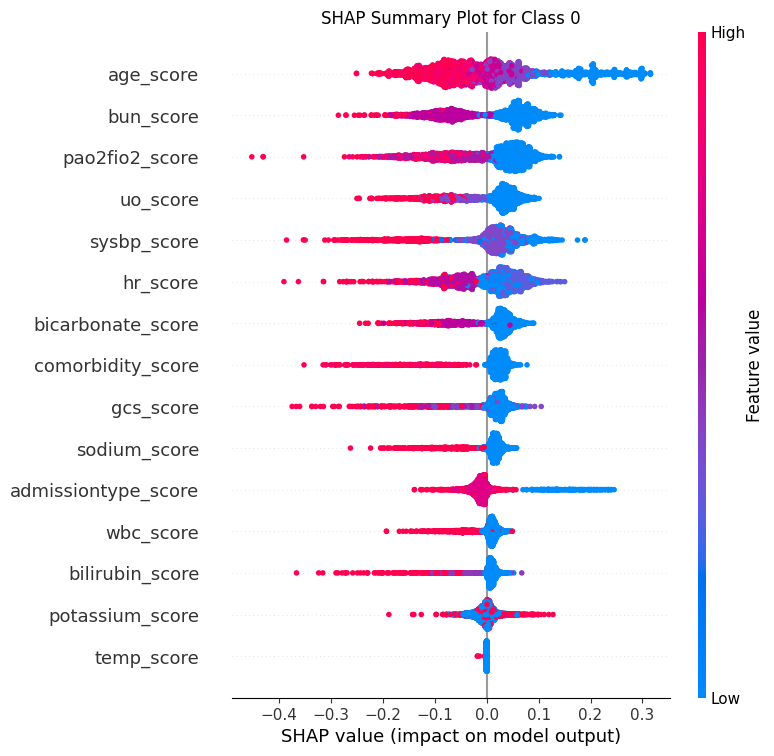

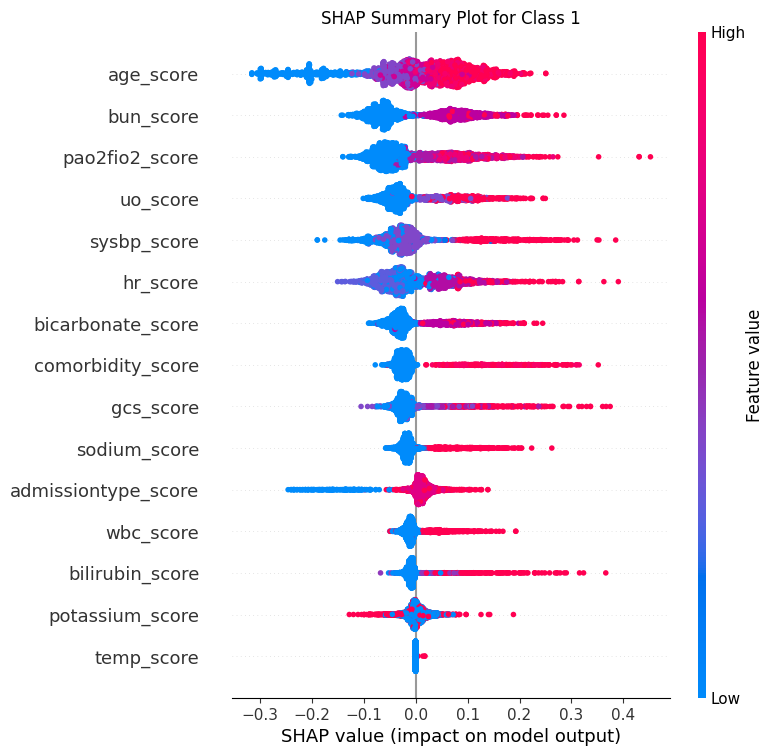

In [25]:
# Extract SHAP values for each class
shap_values_class_0 = shap_values[:, :, 0]  # SHAP values for class 0
shap_values_class_1 = shap_values[:, :, 1]  # SHAP values for class 1

# Summary plot for class 0
shap.summary_plot(shap_values_class_0, features=X_test_balanced, feature_names=X_balanced.columns, plot_type="dot", show=False)
plt.title("SHAP Summary Plot for Class 0")
plt.show()

# Summary plot for class 1
shap.summary_plot(shap_values_class_1, features=X_test_balanced, feature_names=X_balanced.columns, plot_type="dot", show=False)
plt.title("SHAP Summary Plot for Class 1")
plt.show()

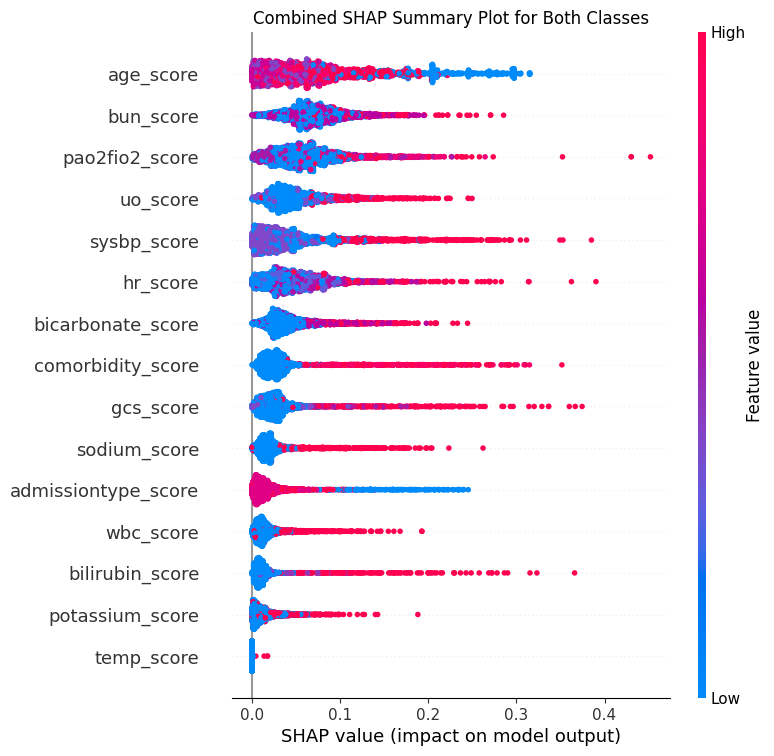

In [26]:
# Calculate the mean absolute SHAP values across both classes
shap_values_mean = np.mean(np.abs(shap_values), axis=2)

# Summary plot using the combined SHAP values
shap.summary_plot(shap_values_mean, features=X_test_balanced, feature_names=X_balanced.columns, plot_type="dot", show=False)
plt.title("Combined SHAP Summary Plot for Both Classes")
plt.show()
